## Variables experimentales
**Variables independientes:**
-  Voltaje de frenado: $U_c \; \left[\text{V}\right]$ (medida directa)
   -  Rango: $U_c \in \left[-4.00, 0.00\right] \text{ V}$
   -  Incertidumbre: $\Delta U_c = U_c \cdot 1\% + (5 \text{ V}) \cdot 0.5\%$ [(según el facricante)](https://www.leybold-shop.com/sensor-cassy-2-524013.html)
-  Longitud de onda: $\lambda \; \left[\text{nm}\right]$ (especificada por el fabricante)
   -  Valores: $\lambda \in \left\{578 \text{ nm}, 546 \text{ nm}, 436 \text{ nm}, 405 \text{ nm}, 365 \text{ nm}\right\}$
   -  Incertidumbre: $\Delta \lambda = 2 \text{ nm}$ [(referencias en la guía)](https://www.leybold-shop.com/catalogsearch/result/?q=Interference+filter)
-  Apertura del diafragma: $A \; \left[\text{u.a.l}\right]$ (unidades arbitrarias de longitud, medida directa)
   -  Rango: $A \in \left[0.0, 3.0\right] \text{ u.a.l.}$
   -  Incertidumbre: $\Delta A = 0.2 \text{ u.a.l.}$ (mitad de la apreciación intrumental $0.5/2$)

**Variables dependientes:**
-  Corriente fotoeléctrica: $I \; \left[\text{pA}\right]$ (medida directa)
   -  Rango: $I \in \left[-20.0, 100.0\right] \text{ pA}$
   -  Incertidumbre: $\Delta I = 0.1 \text{ pA}$ [(incertidumbre instrumental)](https://www.leybold-shop.com/sensor-cassy-2-524013.html)

In [43]:
#@title Librerías utilizadas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [188]:
#@title Funciones
def data_from_file(file_dir):
  data_p = pd.read_csv(file_dir, delimiter=';', header=1)
  data_s = pd.read_csv(file_dir, delimiter=';', header=None, nrows=1)
  data_p = np.transpose(data_p.to_numpy(dtype=np.float64))
  data_s = data_s.loc[0][1::2].tolist()

  medidas = []
  for i in range(len(data_s)):
    U_c =  data_p[2*i]
    I =  data_p[2*i + 1]
    medidas.append({
      'parametro_variable': data_s[i],
      'U_c': U_c[~np.isnan(U_c)],
      'I': I[~np.isnan(I)],
    })

  return medidas


def percentile_range(Range, x, y):
  X, Y = x.copy(), y.copy()  # Avoid pass-by-reference alterations
  
  Y_below = np.percentile(Y, Range[0]*100, method='inverted_cdf')
  Y_above = np.percentile(Y, Range[1]*100, method='inverted_cdf')

  mask_below = Y >= Y_below
  mask_above = Y <= Y_above

  X = X[mask_below & mask_above]
  Y = Y[mask_below & mask_above]

  N = len(Y)
  N_below = np.ceil(Range[0]*N) - (~mask_below).sum()
  N_above = np.ceil((1 - Range[1])*N) - (~mask_above).sum()

  new_X = X.copy()
  new_Y = Y.copy()

  i = j = k = 0
  while i < N_below:
    if Y[k] == Y_below:
      new_X = np.delete(new_X, k - i)
      new_Y = np.delete(new_Y, k - i)
      i += 1
    k += 1

  k = -1
  while j < N_above:
    if Y[k] == Y_above:
      new_X = np.delete(new_X, k + j)
      new_Y = np.delete(new_Y, k + j)
      j += 1
    k += 1

  return new_X, new_Y


def OLS_regr(X, Y, **kwargs):
  N = len(X)
  SX = np.sum(X)
  SY = np.sum(Y)
  SXX = np.sum(X*X)
  SYY = np.sum(Y*Y)
  SXY = np.sum(X*Y)

  P1 = SX*SY - N*SXY
  P2 = SX*SXY - SY*SXX
  Q = SX**2 - N*SXX

  a = P1/ Q
  b = P2 / Q

  linear_X = a*X + b
  ji2 = np.sum(np.power(Y - linear_X, 2))

  SE_a = np.sqrt((ji2/(N - 2))*(N/(-Q)))
  SE_b = np.sqrt((ji2/(N - 2))*(SXX/(-Q)))
  r = (-P1)/(np.sqrt((-Q)*(N*SYY - SY**2)))

  if N < 30:
    SE_a *= t.ppf(.975, N - 1)
    SE_b *= t.ppf(.975, N - 1)

  for key, value in kwargs.items():
    if key == 'Delta_X':
      Delta_X = value
      continue
    elif key == 'Delta_Y':
      Delta_Y = value
      continue
  try:
    Delta_X
    Delta_Y
  except NameError:
    return a, b, SE_a, SE_b, r
  else:
    Delta_SX = np.sqrt(np.sum(np.power(Delta_X, 2)))
    Delta_SY = np.sqrt(np.sum(np.power(Delta_Y, 2)))
    Delta_SXX = 2 * np.sqrt(np.sum(np.power(X * Delta_X, 2)))
    Delta_SXY = np.sqrt(np.sum(np.power(X * Delta_Y, 2) + np.power(Delta_X * Y, 2)))

    Delta_P1 = np.sqrt((SX * Delta_SY)**2 + (Delta_SX * SY)**2 + (N * Delta_SXY)**2)
    Delta_P2 = np.sqrt((SX * Delta_SXY)**2 + (Delta_SX * SXY)**2 + (SY * Delta_SXX)**2 + (Delta_SY * SXX)**2)
    Delta_Q = np.sqrt(4 * (SX * Delta_SX)**2 + (N * Delta_SXX)**2)

    Delta_a = np.sqrt((Delta_P1 * Q)**2 + (P1 * Delta_Q)**2)
    Delta_b = np.sqrt((Delta_P2 * Q)**2 + (P2 * Delta_Q)**2)

    return a, b, SE_a, SE_b, Delta_a, Delta_b, r



In [191]:
#@title Extracción de datos de archivos .csv
medida_apertura_1 = data_from_file('https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/apertura_1.csv')
medida_lambda_578 = data_from_file('https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/lambda_578.csv')
medida_lambda_436 = data_from_file('https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Efecto%20fotoel%C3%A9ctrico/lambda_436.csv')

In [189]:
#@title Colores y marcadores
# facecolor
colores_lambda_578 = ['#292a00', '#535500', '#7d8000', '#a6aa00', '#cfd400', '#f9ff00']
colores_lambda_436 = ['#05002a', '#0a0055', '#0e0080', '#1300aa', '#1800d4', '#1d00ff']
colores_apertura_1 = ['#f9ff00', '#96ff00', '#1d00ff', '#8200c8', '#000000']

# edgecolor
edgec_lambda_578 = ['#d49300', '#d49300', '#d49300', '#d49300', '#d49300', '#ffb000']

# markers
#markers = ['s', 'D', 'P', 'X', '^', 'o']

# Tamaño de fuente en todas las gráficas
plt.rcParams['font.size'] = 18

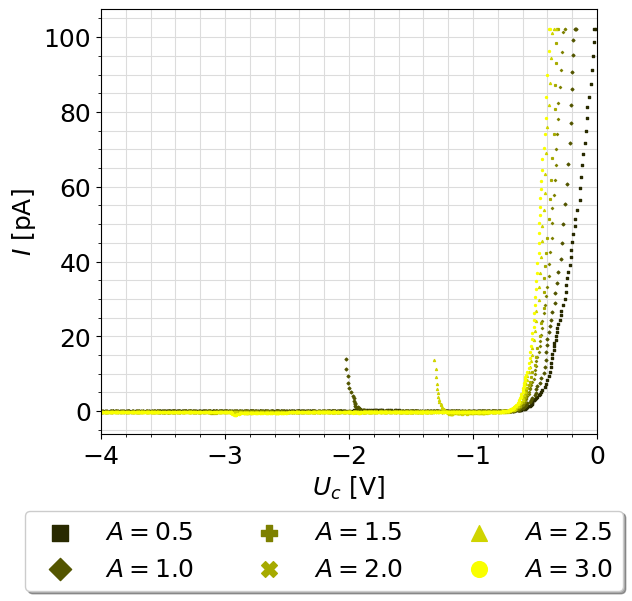

In [171]:
#@title Gráfica con apertura variable ($\lambda = 578 \text{ nm}$)
fig, ax = plt.subplots(layout='constrained')
for i in range(len(medida_lambda_578)):
  apertura = medida_lambda_578[i]['parametro_variable']
  ax.scatter(
    medida_lambda_578[i]['U_c'],
    medida_lambda_578[i]['I'],
    marker=markers[i],
    s=2,
    #lw=.4,
    fc=colores_lambda_578[i],
    #ec=edgec_lambda_578[i],
    zorder=2,
    label=f'$A = {apertura:.1f}$'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

Como se puede observar para las curvas correspondientes a una apertura de $A = 1.0$ y $A = 2.5$ se registraron picos de corriente posiblemente por inducción externa dada la escala de la corriente medida.

Text(0.055, 0.64, '$I$ [pA]')

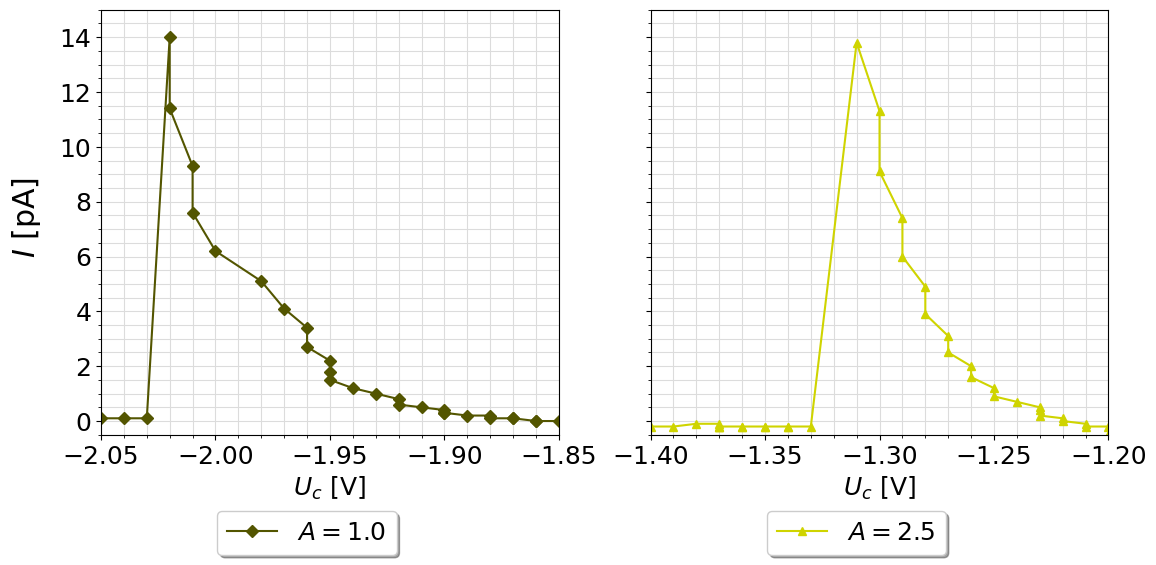

In [181]:
#@title Gráfica de los picos con $\lambda = 578 \text{ nm}$ contante y $A = 1.0, \; 2.5$ 
fig, axs = plt.subplots(1, 2, figsize=(13, 4.8), layout='constrained', sharey=True)

apertura_1 = medida_lambda_578[1]['parametro_variable']
axs[0].plot(
  medida_lambda_578[1]['U_c'],
  medida_lambda_578[1]['I'],
  marker=markers[1],
  ms=6,
  c=colores_lambda_578[1],
  zorder=2,
  label=f'$A = {apertura_1:.1f}$'
)
axs[0].grid(True, which='both', color='gainsboro')
axs[0].minorticks_on()
axs[0].set_xlabel('$U_c$ [V]')
axs[0].set_xlim([-2.05, -1.85])
axs[0].set_ylim([-0.5, 15])
box_1 = axs[0].get_position()
axs[0].set_position([box_1.x0, box_1.y0 + box_1.height * 0.1, box_1.width, box_1.height * 1.15])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3)

apertura_4 = medida_lambda_578[4]['parametro_variable']
axs[1].plot(
  medida_lambda_578[4]['U_c'],
  medida_lambda_578[4]['I'],
  marker=markers[4],
  ms=6,
  c=colores_lambda_578[4],
  zorder=2,
  label=f'$A = {apertura_4:.1f}$'
)
axs[1].grid(True, which='both', color='gainsboro')
axs[1].minorticks_on()
axs[1].set_xlabel('$U_c$ [V]')
axs[1].set_xlim([-1.4, -1.2])
axs[1].set_ylim([-0.5, 15])
box_2 = axs[1].get_position()
axs[1].set_position([box_2.x0, box_2.y0 + box_2.height * 0.1, box_2.width, box_2.height * 1.15])
axs[1].legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3)

fig.supylabel('$I$ [pA]', x=0.055, y=0.64)

Con tal de solucionar esto, se va a utilizar un método de [medidas de escala robustas](https://es.wikipedia.org/wiki/Medidas_de_escala_robustas). Este método se basa en tomar los datos que se encuentran en un rango de percentiles simétrico respecto al $50\%$, los rangos más comunes son el rango del $25\%$ al $75\%$ ([IQR](https://en.wikipedia.org/wiki/Interquartile_range)) y el rango del $10\%$ al $90\%$ (IDR), sin embargo, dado que la cantidad de datos dentro de los picos es bastante pequeña entonces se usará el rango del $7\%$ al $93\%$ que es [similar a tomar un los valores a una distancia de $1.5$ veces la desviación estándar respecto a la media de una distribución normal](https://en.wikipedia.org/wiki/Interdecile_range).

Se decide usar este tipo de métodos sobre las medidas convencionales de escala dado que estos últimos, al involucrar la desviación estándar, el estimador principal tiene un sesgo estadístico porque esta dispersión toma en cuenta información de los datos que no deberían estar, es, decir, eliminar los datos con $1.5$ veces la desviación estándar no va a reproducir el comportamiento ideal dado que la desviación estándar va a ser más grande de lo que debería ser si no estuvieran estos datos.

In [185]:
#@title Procesamiento de los picos por rango de percentiles ($7\%$ a $93\%$)
V_lim_1 = -0.85
I_1 = medida_lambda_578[1]['I']
mask_1 = medida_lambda_578[1]['U_c'] <= V_lim_1
I_1_const = I_1[mask_1]
U_1_const = medida_lambda_578[1]['U_c'][mask_1]

V_lim_4 = -0.8
I_4 = medida_lambda_578[4]['I']
mask_4 = medida_lambda_578[4]['U_c'] <= V_lim_4
I_4_const = I_4[mask_4]
U_4_const = medida_lambda_578[4]['U_c'][mask_4]

U_1_const, I_1_const = percentile_range((.07, .93), U_1_const, I_1_const)
medida_lambda_578[1]['U_c'] = np.append(U_1_const, medida_lambda_578[1]['U_c'][~mask_1])
medida_lambda_578[1]['I'] = np.append(I_1_const, I_1[~mask_1])

U_4_const, I_4_const = percentile_range((.07, .93), U_4_const, I_4_const)
medida_lambda_578[4]['U_c'] = np.append(U_4_const, medida_lambda_578[4]['U_c'][~mask_4])
medida_lambda_578[4]['I'] = np.append(I_4_const, I_4[~mask_4])

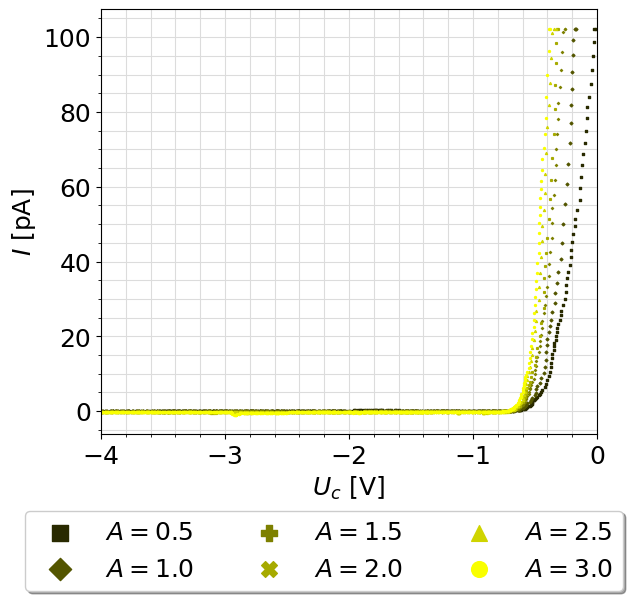

In [186]:
#@title Gráfica de los datos sin pico
fig, ax = plt.subplots(layout='constrained')
for i in range(len(medida_lambda_578)):
  apertura = medida_lambda_578[i]['parametro_variable']
  ax.scatter(
    medida_lambda_578[i]['U_c'],
    medida_lambda_578[i]['I'],
    marker=markers[i],
    s=2,
    #lw=.4,
    fc=colores_lambda_578[i],
    #ec=edgec_lambda_578[i],
    zorder=2,
    label=f'$A = {apertura:.1f}$'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

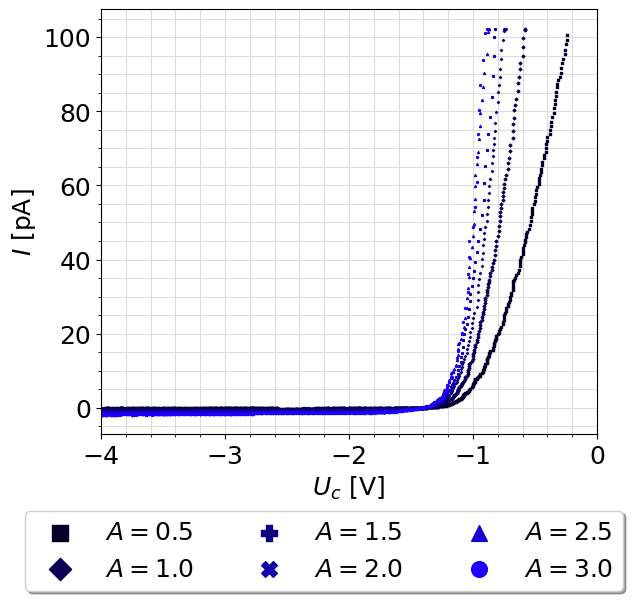

In [172]:
#@title Gráfica con apertura variable ($\lambda = 436 \text{ nm}$)
fig, ax = plt.subplots(layout='constrained')
for i in range(len(medida_lambda_436)):
  apertura = medida_lambda_436[i]['parametro_variable']
  ax.scatter(
    medida_lambda_436[i]['U_c'],
    medida_lambda_436[i]['I'],
    marker=markers[i],
    s=2,
    fc=colores_lambda_436[i],
    zorder=2,
    label=f'$A = {apertura:.1f}$'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)

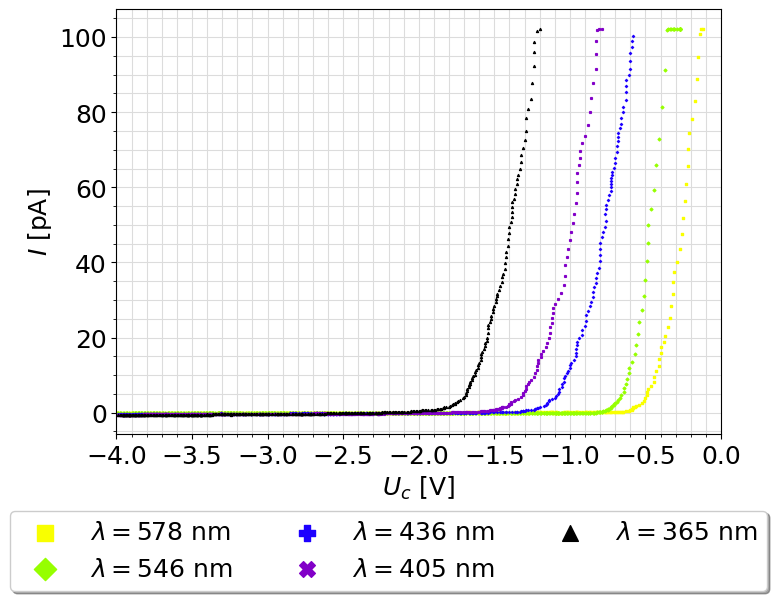

In [180]:
#@title Gráfica con apertura variable ($\lambda = 578 \text{ nm}$)
fig, ax = plt.subplots(figsize=(7.8, 4.8), layout='constrained')
for i in range(len(medida_apertura_1)):
  apertura = medida_apertura_1[i]['parametro_variable']
  ax.scatter(
    medida_apertura_1[i]['U_c'],
    medida_apertura_1[i]['I'],
    marker=markers[i],
    s=2,
    fc=colores_apertura_1[i],
    zorder=2,
    label=f'$\lambda = {apertura}$ nm'
  )
ax.grid(True, which='both', color='gainsboro')
ax.minorticks_on()
ax.set_xlabel('$U_c$ [V]')
ax.set_ylabel('$I$ [pA]')
ax.set_xlim([-4, 0])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), fancybox=True, shadow=True, ncol=3, markerscale=8)